<a href="https://colab.research.google.com/github/HirakawaTakumi/gpytorch_test/blob/master/gp_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import numpy as np
import time 
import math
import matplotlib.pyplot as plt
import time

!pip install gpytorch
import gpytorch

     |████████████████████████████████| 215kB 9.2MB/s 
  Created wheel for gpytorch: filename=gpytorch-0.3.5-py2.py3-none-any.whl size=349720 sha256=896b4dd52bd85aed1d9a369ee786c0336339745dc2d705a4baf01249fe0b14e6
  Stored in directory: /root/.cache/pip/wheels/d6/31/88/c43a94e0073a54056ac663366f2195de36535b38a81a378196
Successfully built gpytorch


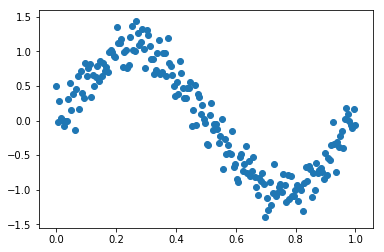

In [0]:
x_train  = torch.linspace(0,1,200)
y_train = torch.sin(x_train * (2 * math.pi)) + torch.randn(x_train.size()) * 0.2
xx = torch.linspace(0,1,200)
plt.scatter(x_train,y_train)

##フルスクラッチ実装

In [0]:
def kernel_function(x,x_dot):
  theta_1 = 1.0
  theta_2 = 1.0
  return theta_1*torch.exp(-(x-x_dot)**2/theta_2) 


In [0]:
def gpr(x_train,x_dot,y_train,kernel_function):
  N = len(x_train)
  K =  torch.zeros((N,N))
  theta3 = 0.1
  for i in range(N):
    for j in range(N):
      K[i,j] = kernel_function(x_train[i],x_train[j])
      if j==i:
        K[i,j]+= theta3 #誤差カーネル
  K_inv = torch.inverse(K)
  yy = torch.matmul(K_inv,y_train)
  #print(K) 
  #print(yy)
  #plt.imshow(K,cmap="Greys_r")

  M = len(x_dot)
  k = torch.zeros((M,N))
  
  
  time1 = time.perf_counter()
  for m in range(M):
    for n in range(N):
      k[m,n] = kernel_function(x_train[n],x_dot[m])
    s = kernel_function(x_dot[m],x_dot[m]) + theta3
    
  mu =torch.matmul(k,yy)
  k_Kinv = torch.matmul(k,K_inv)
  var = s - torch.matmul(k_Kinv,torch.t(k))
  print(time.perf_counter()-time1)
  #print(k)
  #print(s)
  #print(mu)
  #print(var)

  return mu,var

In [0]:
mu,var = gpr(x_train,xx,y_train,kernel_function)

1.535134279999994


No handles with labels found to put in legend.


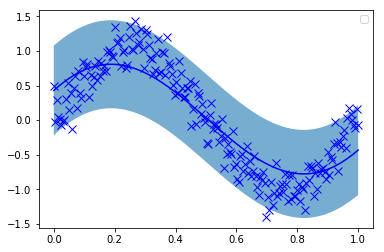

In [0]:
mu = mu.numpy().ravel()#行列→1次元の配列の変換
xx.numpy().ravel()
plt.plot (x_train.numpy(), y_train.numpy(), 'bx', markersize=8)
plt.plot (xx.numpy(), mu, 'b-')
plt.fill_between(xx, mu + 2*torch.sqrt(torch.diag(var)).numpy(), mu - 2*torch.sqrt(torch.diag(var)).numpy(),alpha = 0.6)
plt.legend()

##gpytorchによる実装

In [0]:
class FancyGPWithPriors(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(FancyGPWithPriors, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-2),
)

model = FancyGPWithPriors(x_train, y_train, likelihood)

ハイパーパラメータ設定（できてるのか？）

In [0]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.2),
    'covar_module.base_kernel.lengthscale': torch.tensor(1.),
    'covar_module.outputscale': torch.tensor(0.68)
}

model.initialize(**hypers)
print(
    model.likelihood.noise_covar.noise.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item()
)

0.19999998807907104 1.0 0.6800000071525574


モデルを評価モードにして実行

In [0]:
model.eval()
likelihood.eval()


t = time.perf_counter()
observed_pred = likelihood(model(xx))
print("process time:%f"%(time.perf_counter()-t))

process time:0.071375


/usr/local/lib/python3.6/dist-packages/gpytorch/models/exact_gp.py:247: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


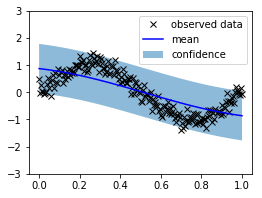

In [0]:
f,ax = plt.subplots(1,1,figsize=(4,3))

lower,upper =observed_pred.confidence_region()

ax.plot(x_train.numpy(),y_train.numpy(),'kx')

ax.plot(xx.numpy(),observed_pred.mean.detach().numpy(),'b')

ax.fill_between(xx,lower.detach().numpy(),upper.detach().numpy(),alpha = 0.5)

ax.set_ylim([-3,3])
ax.legend(['observed data' ,'mean', 'confidence'])